# Introduction
In this project we will try to predict the number of bikes rented in a given hour. The data has been taken from  University of California, Irvine's website.
The descriptions for the relevant columns in this project is as follows:<br>
- instant - A unique sequential ID number for each row
- dteday - The date of the rentals
- season - The season in which the rentals occurred
- yr - The year the rentals occurred
- mnth - The month the rentals occurred
- hr - The hour the rentals occurred
- holiday - Whether or not the day was a holiday
- weekday - Whether or not the day was a weekday
- workingday - Whether or not the day was a working day
- weathersit - The weather (as a categorical variable)
- temp - The temperature, on a 0-1 scale
- atemp - The adjusted temperature
- hum - The humidity, on a 0-1 scale
- windspeed - The wind speed, on a 0-1 scale
- casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- registered - The number of registered riders (people who had already signed up)
- cnt - The total number of bike rentals (casual + registered)<br>

So by reading file in pandas, lets get started


In [43]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [44]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In this project the target variable is `'cnt'`. So lets' check this target variable and it's trend by plotting a histogram of it.

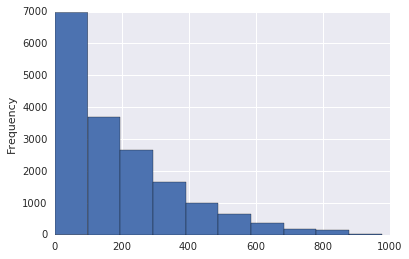

In [45]:
bike_rentals['cnt'].plot.hist()
plt.show()

Also its always a good strategy to check which variable correlates strongly with our target variable, if correlation is strong then we can say that the variable is more effective and should be inclueded in features for our machine learning model and vice versa.

In [46]:
# calculating correlations for cnt feature only
bike_rentals.corr()['cnt'].abs()

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday       0.030927
weekday       0.026900
workingday    0.030284
weathersit    0.142426
temp          0.404772
atemp         0.400929
hum           0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

In above section we can see the correlation for cnt variable, but for checking the correlation of all variables we can't just check the matrix. For such task its advisable to visualize the data and then compare it and select the features. So we will use sns heatmap functions to plot the correlation matrix.

In [47]:
import seaborn as sns

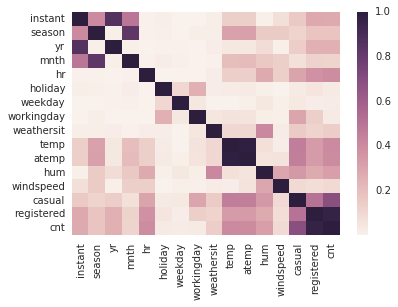

In [48]:
sns.heatmap(bike_rentals.corr().abs())
plt.show()

In above section we can check that `temp` and `atemp` correlates highly with each other. So we will be selecting only one of them for our model. Also we can see that `hr` has not any high correlation with `cnt`, but it was expected to be have high correlation. So lets do some feature engineering on `hr` column. We can divide `hr` or 24 hours in 4 section<br>
- 1 = [6,12)
- 2 = [12,18)
- 3 = [18,24)
- 4 = [0,6)

In [49]:
def assign_label(num):
    if num>=6 and num<12:
        return 1
    if num>=12 and num<18:
        return 2
    if num>=18 and num<24:
        return 3
    return 4
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

In [50]:
# checking if our label instantiation worked properly or not
bike_rentals[['time_label','hr']].head(20)

,time_label,hr
0,4,0
1,4,1
2,4,2
3,4,3
4,4,4
5,4,5
6,1,6
7,1,7
8,1,8
9,1,9


## Metric Selection
Now that we have done some feature engineering it is now time to apply machine learning model. But before that we have to select a metric to check the accuracy of our model. In machine learning we can check the validity of our model only if we select a relevent metric properly.<br>
As this is regression problem then we have to select the metric which measures the proporition of deviation of results from true predicition. So we have to select metric which measure the difference between predicted and true value. So we can use regression or mean_squared_error metric.

In [51]:
# importing mean_squared_error metric
from sklearn.metrics import mean_squared_error

# assigning target variable to preditction columns
target = 'cnt'

# sepearating data in training and testing dataset in 80:20 proportion
train = bike_rentals.sample(frac=0.8,random_state=1)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

## Feature Selection
In this part we will try to select the features which are highly correlated with 'cnt' feature so we could have better model. Let's select the features which have correlation higher thatn 0.3<br>
Features like `instant, dteday, yr` don't add any information to our model so its better to drop them first.<br>
Also features like `casual` and `registered` should not be included as `cnt` feature is just the some of these two features.

In [52]:
drop_features = ['instant','dteday','yr','cnt','casual','regsitered']
features = bike_rentals.corr()[target].abs()
#features = features.index.drop(drop_features)
features = features[features>0.3]
features

hr            0.394071
temp          0.404772
atemp         0.400929
hum           0.322911
casual        0.694564
registered    0.972151
cnt           1.000000
time_label    0.378318
Name: cnt, dtype: float64

In [53]:
# we can see that casual, registered, cnt features are available so lets drop them first
features = features.drop(['cnt','casual','registered']).index
features

Index(['hr', 'temp', 'atemp', 'hum', 'time_label'], dtype='object')

## Feature Selection 2
Now that we have selected the set of features now we would like to select if these features are highly corelated or not. If there are some features which are highly correlated to different feature other than cnt then we will have to select only one feature from them.<br>
Also we have to note that we will have to drop `hr` feture as we have already engineered it to produce `time_label`.

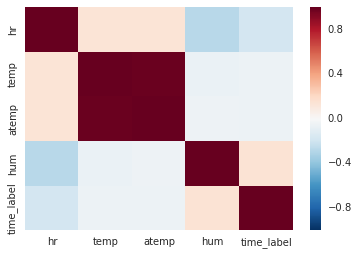

In [54]:
sns.heatmap(bike_rentals[features].corr())

Now we can see that temp and atemp are highly correlated with each other. So we should only select only one feature from them. Because if we select both features then the model will be biased on temp and atemp.

In [55]:
bike_rentals[features].head(20)

,hr,temp,atemp,hum,time_label
0,0,0.24,0.2879,0.81,4
1,1,0.22,0.2727,0.80,4
2,2,0.22,0.2727,0.80,4
3,3,0.24,0.2879,0.75,4
4,4,0.24,0.2879,0.75,4
5,5,0.24,0.2576,0.75,4
6,6,0.22,0.2727,0.80,1
7,7,0.20,0.2576,0.86,1
8,8,0.24,0.2879,0.75,1
9,9,0.32,0.3485,0.76,1


From just checking we can't say which has great variance. So we will check their variance manually.

In [56]:
bike_rentals[['temp','atemp']].var()

temp     0.037078
atemp    0.029532
dtype: float64

Result is indicating that temp has more variance than atemp. So we will select temp as in our selected features. But before that let us check if it is more correlated to our target variable or not.

In [57]:
bike_rentals[['temp','atemp','cnt']].corr()

,temp,atemp,cnt
temp,1.000000,0.987672,0.404772
atemp,0.987672,1.000000,0.400929
cnt,0.404772,0.400929,1.000000


So again temp wins as it has high correlating with our target variable also.

In [58]:
features = features.drop(['atemp','hr'])
features

Index(['temp', 'hum', 'time_label'], dtype='object')

# Model Training and Testing

In [59]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression()
clf.fit(train[features],train[target])
pred = clf.predict(test[features])
print(mean_squared_error(test[target],pred))

20642.8759822


So the error is to large and this model is not permissible to use in real life for predicition task. Let us select more features and see if error goes down or not.

In [61]:
features = bike_rentals.columns
feature_drop = ['hr','atemp','cnt','instant','dteday','casual','registered']
features = features.drop(feature_drop)
features

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'hum', 'windspeed', 'time_label'],
      dtype='object')

In [62]:
clf.fit(train[features],train[target])
print('train_error',mean_squared_error(train[target],clf.predict(train[features])))
print('test_errir',mean_squared_error(test[target],clf.predict(test[features])))

train_error 19461.2385763
test_errir 18921.13723


So the error did decreased!!!
Now we will compare our result with some other model to check which model works good.
# Decision Tree Regressor

In [63]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse
dtr = DecisionTreeRegressor()
dtr.fit(train[features],train[target])
print('train_error',mse(train[target],dtr.predict(train[features])))
print('test_error',mse(test[target],dtr.predict(test[features])))

train_error 337.96221439
test_error 20232.4140715


In [64]:
dtr.max_features_

11

We can see in decision tree regressor the training error is 338 while the test error is around 20000. This means that our model overfits the training sample which is not good. Lets try to decrease the depth as well as increase the minimum required samples at leaf and check the error.

In [65]:
dtr1 = DecisionTreeRegressor(max_depth=4,min_samples_split=5)
dtr1.fit(train[features],train[target])
print('train_error',mse(train[target],dtr1.predict(train[features])))
print('test_error',mse(test[target],dtr1.predict(test[features])))

train_error 16354.3607563
test_error 15830.3850553


In [66]:
dtr1 = DecisionTreeRegressor(max_depth=6,min_samples_split=8)
dtr1.fit(train[features],train[target])
print('train_error',mse(train[target],dtr1.predict(train[features])))
print('test_error',mse(test[target],dtr1.predict(test[features])))

train_error 14740.3063083
test_error 14862.1506512


We can see that the model is becoming more and more generalized as we are selecting different max_depth and min_samples_split values. And error also has decreaed from 20,232 to 14,862. That is a good indication.

In [67]:
dtr2 = DecisionTreeRegressor(min_samples_leaf=5)
dtr2.fit(train[features],train[target])
print('train_error',mse(train[target],dtr2.predict(train[features])))
print('test_error',mse(test[target],dtr2.predict(test[features])))

train_error 7069.79685083
test_error 15254.3796336


# Random Forest Regressor
Now lets check the model with random forest regressor model and try to optimize our hyperparameters.

In [68]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(min_samples_leaf=5)
rfr.fit(train[features],train[target])
print('train_error',mse(train[target],rfr.predict(train[features])))
print('test_error',mse(test[target],rfr.predict(test[features])))

train_error 7411.30124102
test_error 12001.0683994


In [69]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=100,min_samples_leaf=5)
rfr.fit(train[features],train[target])
print('train_error',mse(train[target],rfr.predict(train[features])))
print('test_error',mse(test[target],rfr.predict(test[features])))

train_error 7040.93345496
test_error 11559.1294019


In [70]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(min_samples_leaf=5,max_depth=5)
rfr.fit(train[features],train[target])
print('train_error',mse(train[target],rfr.predict(train[features])))
print('test_error',mse(test[target],rfr.predict(test[features])))

train_error 14986.0768076
test_error 14565.278804


Now just drop datatime type columns and target columns from features so we can use most of the features.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
features = train.columns
drop_cols = ['cnt','casual','registered','dteday','index']
features = features.drop(drop_cols)
rfr = RandomForestRegressor(min_samples_leaf=5,max_depth=5)
rfr.fit(train[features],train[target])
print('train_error',mse(train[target],rfr.predict(train[features])))
print('test_error',mse(test[target],rfr.predict(test[features])))

In this project we 